$$
\def\abs#1{\left\lvert #1 \right\rvert}
\def\Set#1{\left\{ #1 \right\}}
\def\mc#1{\mathcal{#1}}
\def\M#1{\boldsymbol{#1}}
\def\R#1{\mathsf{#1}}
\def\RM#1{\boldsymbol{\mathsf{#1}}}
\def\op#1{\operatorname{#1}}
\def\E{\op{E}}
\def\d{\mathrm{\mathstrut d}}
\DeclareMathOperator{\Tr}{Tr}
\DeclareMathOperator*{\argmin}{arg\,min}
\def\norm#1{\left\lVert #1 \right\rVert}
$$

# What is adversarial attack and why we care about it?

Despite the effectiveness on a variety of tasks, deep neural networks can be very vulnerable to adversarial attacks. In security-critical domains like facial recognition authorization and autonomous vehicles, such vulnerability against adversarial attacks makes the model highly unreliable. 

An adversarial attack tries to add an imperceptible perturbation to the sample so that a trained neural network would classify it incorrectly. The following is an example of adversarial attack.

<img src="https://i.loli.net/2021/08/10/ngphSTutRjLbErD.jpg" alt="drawing" width="400" align="center"/>



## Adversarial Attacks

### Categories of Attacks
#### Poisoning Attack and Evasion Attack
Poisoning attacks involve manipulating the training process. The manipulation can happen on the training set (by replacing original samples or inserting fake samples) or the training algorithm itself (by changing the logic of the training algorithm). Such attacks either directly cause poor performance of the trained model or make the model fail on certain samples so as to construct a backdoor for future use.

Evasion attacks aim to manipulate the benign samples $\M x$ by a small perturbation $\M \delta$ so that a trained model can no longer classify it correctly. Usually, such perturbations are so small that a human observer cannot notice them. In other words, the perturbed sample "evades" from the classification of the model.

#### Targeted Attack and Non-Targeted Attack
A targeted attack tries to perturb the benign samples $\M x$ so that the trained model classifies it as a given certain class $t\in \mc Y$. A non-targeted attack only tries to perturb the benign samples $\M x$ so that the trained model classifies them incorrectly. 

#### White-Box Attack and Black-Box Attack
For white-box attacks, the attacker has access to all the knowledge of the targeted model. For neural networks, the attacker knows all the information about the network structure, parameters, gradients, etc. 

For black-box attacks, the attacker only knows the outputs of the model when feeding inputs into it. In practice, black-box attacks usually rely on generating adversarial perturbations from another model that the attacker has full access to. 

Black-box attacks are more usual in applications, but the robustness against white-box attacks is the ultimate goal of a robust model because it reveals the fundamental weakness of neuron networks. Thus, most of the study of adversarial robustness focuses on white-box, non-targeted, evasion attacks.

### Examples of White-box Attacking Algorithms
Most white-box attacking algorithms are based on using the gradient calculated by the model to perturb the samples. Two typical examples are Fast Gradient Sign Method (FGSM) attack and its multi-step variant, Projected Gradient Descent (PGD) attack. FGSM attack generates the perturbation as
$$\begin{align}
    \M \delta = \epsilon\text{sgn}\nabla_{\M x}L(\M x, y),
\end{align}$$
where $\epsilon$ controls the perturbation size. The adversarial sample is 
$$\begin{align}
    \M x' = \M x + \M \delta.
\end{align}$$
FGSM attack can be seen as trying to maximizing (single step) the loss of the model. 

PGD attack tries perform the same task, but in a iterative way (at the cost of higher computational time):
$$\begin{align}
    \M x^{t+1} = \Pi_{\M x+\epsilon}\left(\M x^t + \alpha\text{sgn}\nabla_{\M x}L(\M x, y)\right),
\end{align}$$
where $\alpha$ is the step size. $\M x^t$ denote the generated adversarial sample in step $t$, with $\M x^0$ being the original sample. $\Pi$ refers to a projection operation that clips the generated adversarial sample into the valid region: the $\epsilon$-ball around $\M x$, which is $\{\M x':\norm{\M x'-\M x}\leq \epsilon \}$.

In practice, a PGD attack with a relatively small adversarial power $\epsilon$ (small enough to be neglected by human observers) is able to reduce the accuracy of a well-trained model to nearly zero. Because of such effectiveness, researchers often use PGD attacks as a basic check of the adversarial robustness of their models.


#### Implementation of FGSM attack

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

##### Inputs
-  **epsilons** - List of epsilon values to use for the run. It is
   important to keep 0 in the list because it represents the model
   performance on the original test set. Also, intuitively we would
   expect the larger the epsilon, the more noticeable the perturbations
   but the more effective the attack in terms of degrading model
   accuracy. Since the data range here is $[0,1]$, no epsilon
   value should exceed 1.

-  **pretrained_model** - path to the pretrained MNIST model which was
   trained with [pytorch/examples/mnist ](https://github.com/pytorch/examples/tree/master/mnist).
   For simplicity, download the pretrained model [here](https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing).

-  **use_cuda** - boolean flag to use CUDA if desired and available.
   Note, a GPU with CUDA is not critical for this tutorial as a CPU will
   not take much time.

In [7]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

##### Model Under Attack

As mentioned, the model under attack is the same MNIST model from
[pytorch/examples/mnist](https://github.com/pytorch/examples/tree/master/mnist).
You may train and save your own MNIST model or you can download and use
the provided model. The *Net* definition and test dataloader here have
been copied from the MNIST example. The purpose of this section is to
define the model and dataloader, then initialize the model and load the
pretrained weights.


In [8]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

##### FGSM Attack

Now, we can define the function that creates the adversarial examples by
perturbing the original inputs. The ``fgsm_attack`` function takes three
inputs, *image* is the original clean image ($x$), *epsilon* is
the pixel-wise perturbation amount ($\epsilon$), and *data_grad*
is gradient of the loss w.r.t the input image
($\nabla_{x} L(\mathbf{\theta}, \mathbf{x}, y)$). The function
then creates perturbed image as

\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} L(\mathbf{\theta}, \mathbf{x}, y))\end{align}

Finally, in order to maintain the original range of the data, the
perturbed image is clipped to range $[0,1]$.


In [9]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

##### Testing Function

Finally, the central result of this tutorial comes from the ``test``
function. Each call to this test function performs a full test step on
the MNIST test set and reports a final accuracy. However, notice that
this function also takes an *epsilon* input. This is because the
``test`` function reports the accuracy of a model that is under attack
from an adversary with strength $\epsilon$. More specifically, for
each sample in the test set, the function computes the gradient of the
loss w.r.t the input data ($data\_grad$), creates a perturbed
image with ``fgsm_attack`` ($perturbed\_data$), then checks to see
if the perturbed example is adversarial. In addition to testing the
accuracy of the model, the function also saves and returns some
successful adversarial examples to be visualized later.


In [10]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

##### Run Attack

The last part of the implementation is to actually run the attack. Here,
we run a full test step for each epsilon value in the *epsilons* input.
For each epsilon we also save the final accuracy and some successful
adversarial examples to be plotted in the coming sections. Notice how
the printed accuracies decrease as the epsilon value increases. Also,
note the $\epsilon=0$ case represents the original test accuracy,
with no attack.


In [11]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4303 / 10000 = 0.4303
Epsilon: 0.25	Test Accuracy = 2087 / 10000 = 0.2087
Epsilon: 0.3	Test Accuracy = 871 / 10000 = 0.0871


##### Results

Accuracy vs Epsilon

The first result is the accuracy versus epsilon plot. As alluded to
earlier, as epsilon increases we expect the test accuracy to decrease.
This is because larger epsilons mean we take a larger step in the
direction that will maximize the loss. Notice the trend in the curve is
not linear even though the epsilon values are linearly spaced. For
example, the accuracy at $\epsilon=0.05$ is only about 4% lower
than $\epsilon=0$, but the accuracy at $\epsilon=0.2$ is 25%
lower than $\epsilon=0.15$. Also, notice the accuracy of the model
hits random accuracy for a 10-class classifier between
$\epsilon=0.25$ and $\epsilon=0.3$.


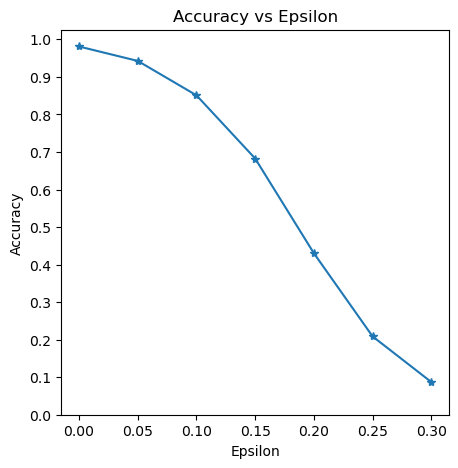

In [12]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

##### Sample Adversarial Examples

Remember the idea of no free lunch? In this case, as epsilon increases
the test accuracy decreases **BUT** the perturbations become more easily
perceptible. In reality, there is a tradeoff between accuracy
degredation and perceptibility that an attacker must consider. Here, we
show some examples of successful adversarial examples at each epsilon
value. Each row of the plot shows a different epsilon value. The first
row is the $\epsilon=0$ examples which represent the original
“clean” images with no perturbation. The title of each image shows the
“original classification -> adversarial classification.” Notice, the
perturbations start to become evident at $\epsilon=0.15$ and are
quite evident at $\epsilon=0.3$. However, in all cases humans are
still capable of identifying the correct class despite the added noise.




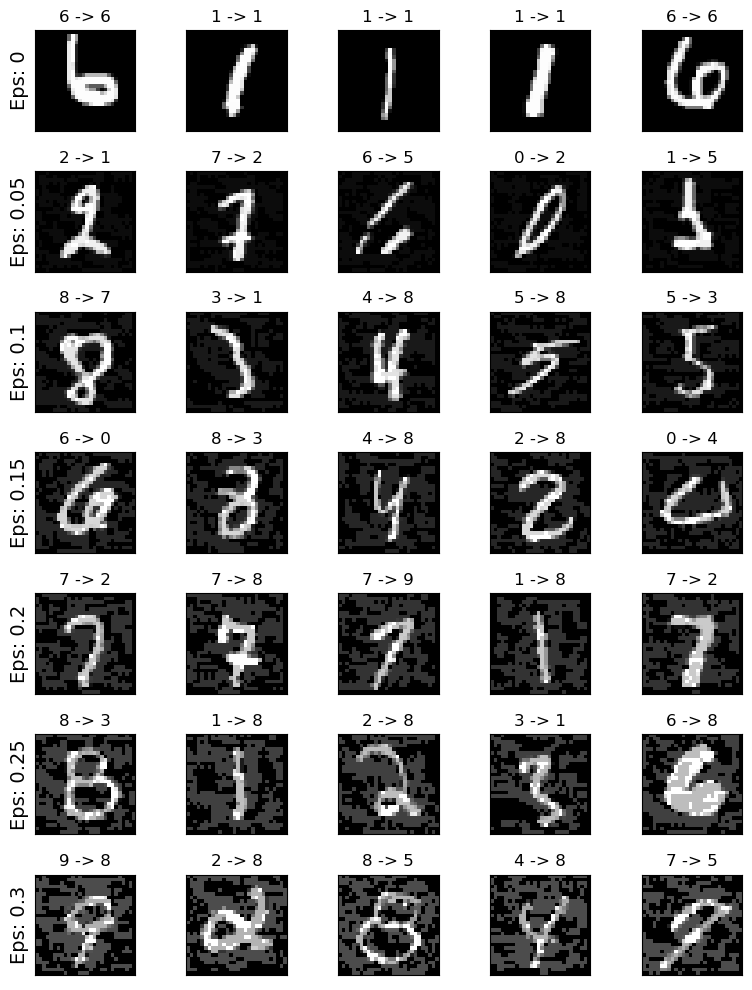

In [13]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Adversarial Training with Perturbed Examples
To defend adversarial attacks, a direct idea is to add perturbations during the training process. Mardy et al. \cite{madry2017} proposed to formulate a robust optimization problem to minimize the adversarial risk instead of the usual empirical risk:
$$\begin{align}
    \min_{\theta} \E_{(\M x, y)\in \mc D} \left[\max_{\norm{\M\delta}_p<\epsilon}L(\M x+\M\delta, y)\right].
\end{align}$$
The inner maximization tries to find perturbed samples that produce a high loss, which is also the goal of PGD attacks. The outer minimization problem tries to find the model parameters that minimize the adversarial loss given by the inner adversaries. 

This robust optimization approach effectively trains more robust models. It has been a benchmark for evaluating the adversarial robustness of models and is often seen as the standard way of adversarial training. Based on this method, many variants were proposed in the following years. They involve using a more sophisticated regularizer or adaptively adjusting the adversarial power. Those methods that add perturbations during training share a common disadvantage of high computational cost.

## Adversarial Training with Stochastic Networks
Stochastic networks refer to the neuron networks that involve random noise layers. Liu et al. proposed Random Self Ensemble (RSE). Their method injects spherical Gaussian noise into different layers of a network and uses the ensemble of multiple forward pass as the final output. The variance of their added noise is treated as a hyper-parameter to be tuned. RSE shows good robustness against PGD attack and C\&W attack. 

Similar to RSE, He et al. proposed Parametric Noise Injection (PNI). Rather than fixed variance, they applied an additional intensity parameter to control the variance of the noise. This intensity parameter is trained together with the model parameters. 

Inspired by the idea of trainable noise, Eustratiadis et al. proposed Weight-Covariance Alignment (WCA) method \cite{wca}. This method adds trainable Gaussian noise to the activation of the penultimate layer of the network. Let $\M g_{\theta}:\mathcal X\rightarrow \mathbb R^D$ be the neural network parameterized by $\theta$ except the final layer and $f_{\M W, \M b}:\mathbb R^D \rightarrow \mathbb R^K$ be the final linear layer parameterized by weight matrix $\M W^{K\times D}$ and bias vector $\M b^{K\times 1}$, where $K=\abs{\mc Y}$ is the number of classes . This WCA method adds a Gaussian noise $\M u \sim \mathcal N_{0, \M\Sigma}$ to the output of penultimate layer $\M g_{\theta}(x)$, where $\M\Sigma^{D\times D}$ is the covariance matrix. Thus, the final output becomes
  $$\begin{align}
  f_{\M W, \M b}\left(\M g_\theta(\M x)\right) = \M W\left(\M g_\theta (\M x)+\M u\right) + \M b.
  \end{align}$$
  
The loss function is defined as
  $$\begin{align}
  L=L_{\text{CE}} + L_{\text{WCA}}+ \lambda \sum_{y\in \mathcal{Y}}\M W_y^{\intercal} \M W_y,
  \end{align}$$
where $L_{\text{CE}}$ is the usual cross-entropy loss, and $L_{\text{WCA}}$ is a term that encourage the noise and the weight of last layer to be aligned with each other. The third term is gives $l^2$ penalty to $\M W_y$ with large magnitude. The WCA regularizer is defined as
  $$\begin{align}
  L_{\text{WCA}} = -\log\sum_{y\in \mathcal{Y}}\M W_y \M\Sigma\M W_y^\intercal .
  \end{align}$$
where $\M W_y$ is the weight vector of the last layer that is associated with class $y$. 

The WCA regularizer encourages the weights associated with the last layer to be well aligned with the covariance matrix of the noise. Larger trained variance corresponding to one feature means this feature is harder to perturb, so putting more weight on such features will force the final layer to focus more on these robust features. 

Models trained with WCA show better performance against PGD attacks on various datasets comparing with the aforementioned approaches. In addition, because of the fact that WCA does not involve generating adversarial samples, the computational time is significantly lower than adversarial training with perturbations. The method we propose is inspired by this WCA method. But instead of adding noise to the penultimate layer, we directly add noise to the output of the final layer.

## Training a neural network with noisy logits

We consider training a model with a noisy representation $\R{Z}$ satisfying the Markov chain:

$$\R{X}\to \R{Z} \to \hat{\R{Y}}$$

Hence, the estimate for $P_{\R{Y}|\R{X}}$ is given by $P_{\R{Y}|\R{Z}}$ and $P_{\R{Z}|\R{X}}$ as
$$P_{\hat{\R{Y}}|\R{X}} (y|x) = E\left[\left.P_{\hat{\R{Y}}|\R{Z}}(y|\R{Z}) \right|\R{X}=x\right].$$


In particular, we propose to set $\R{Z}$ to be the noisy logits of $\hat{\R{Y}}$, i.e.,
$P_{\hat{Y}|\R{Z}}$ is defined by the pmf obtained with the usual softmax function
$$
p_{\hat{\R{Y}}|\RM{z}} (y|\M{z}) := \frac{\exp(z_y)}{\sum_{y'\in \mathcal{Y}} \exp(z_{y'})},
$$
so $z_y$ is the logit for class $y$.

The noisy logit is defined as
$$
\R{Z} = \RM{z}:=[g(y|\R{X})+\R{u}_y]_{y\in \mathcal{Y}}
$$
where
$$g(y|x)\in \mathbb{R}$$
for $(x,y)\in \mathcal{X}\times \mathcal{Y}$
is computed by a neural network to be trained, and $\R{u}_y\sim \mathcal{N}_{0,\sigma_y^2}$ for $y\in \mathcal{Y}$ are independent gaussian random variables with variance $\sigma_y^2>0$. For simplicity, 
$$
$$\begin{align}
\M{g}(x)&:= [g(y|x)]_{y\in \mathcal{Y}}\\
\RM{u}&:=[\R{u}_y]_{y\in \mathcal{Y}}\\
\M{\Sigma}&:=\M{\sigma} \M{I} \M{\sigma}^\intercal \quad \text{with }\M{\sigma}:=[
\sigma_y]_{y\in \mathcal{Y}},
\end{align}$$
$$ which are referred to as the (noiseless) logits, additive noise (vector) and its (diagonal) covariance matrix respectively. Hence, $P_{\R{Z}|\R{X}}$ is defined by the multivariate gaussian density function
$$
p_{\RM{z}|\R{X}}(\M{z}|x) = \mathcal{N}_{\M{g}(x),\Sigma}(\M{z})
$$
for $x\in \mathcal{X}$ and $\M{z}\in \mathbb{R}^{\abs{\mathcal{Y}}}$. 

The loss function used for training the neural network is derived from

$$
L := E\left[-\log p_{\hat{\R{Y}}|\R{X}}(\R{Y}|\R{X})\right] - \log \sum_{y\in \mathcal{Y}}\sigma_y^2 + \lambda\left(\sum_{y\in \mathcal{Y}}\sigma_y^2\right)
$$
